<div style="text-align: center;">
    <h1>Norwegian Artificial Intelligence Research Consortium</h1>
</div>

---

<!-- <img src='photos/norge.png' style='float: left;' width=10% /> -->

<div style="display: flex;">
    <img src='photos/nora.png' style="height: 30%; width: 30%;" />
    <img src='photos/norge.png' style="height: 30%; width: 10%;"  />
</div>

---

<div style="text-align: center;">
    <h1>RoadAI - Reducing emissions in road construction</h1>
</div>

<img src='photos/roadai.png' width=80% />

1.5% of Norwegian CO2 emission comes from construction machines. How can we use data to reduce this emission?

The participants will be provided with data from a road construction site in Viken including GPS data from dump trucks, machine data including daily fuel consumption, and drone maps of the construction site. In addition, we have a small dataset of vibration data from a subset of dumpers, and of course public data such as weather, maps etc.

The challenge is to demonstrate how the data can be exploited for road construction to become more sustainable. Sustainability can be interpreted as directly reduced emission, but also as minimizing construction time and impact on the surroundings. The current status is that many processes are manually controlled, and could benefit from automated decision support: This can for example be obtained through:

* Reduction of idle time
* Optimal flow of dump trucks on the construction site
* Minimization of unnecessary driving
* Optimal driving style with minimal acceleration
* <mark>Automated classification of road types for improved planning</mark>
* Automated progress reports
* Automated detection of load cycles (when excavators fill the dumpers)

---

I will deliver my second solution for automated classification of road types for improved planning 

   - predict regimes or clusters based on vibration data

#### ---

# Quick_Links

Use the quick links to get to different sections of the notebook. 

Also, there is **Return to Home** at each section's end, where you can navigate quickly across sections.

### A: Data Input
- [1. Create Spark Session](#1_Start_Spark_Session)
- [2. Data Ingestion](#2_Data_Ingestion)
- [3. Exploratory Data Analysis](#3_Exploratory_Data_Analysis)

### B: Data Preparation
- [4. Data Preprocessing](#4_Data_Preprocessing)

### C: Clustering
- [5. Clustering](#5_Clustering)

---

In [1]:
# Uncomment to install the required packages
!pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1_Start_Spark_Session

## Create a SparkSession

The SparkSession.builder method creates a new instance of the SparkSession class. The timezone is set here to `UTC` so that datetime values are not adjusted to the timezone of the local machine.

> **Background -** SparkSession is the entry point to using Spark functionality in a Python application. It provides various methods for creating DataFrames, executing SQL queries, and interacting with Spark's distributed computing capabilities.

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import current_timestamp

# Create SparkSession with timezone configuration set to UTC
spark = SparkSession.builder \
    .appName("Spark Timestamp Example") \
    .config("spark.sql.session.timeZone", "UTC") \
    .getOrCreate()

# I invoked suppress all Spark warnings
spark.sparkContext.setLogLevel("ERROR")  # or "FATAL" for even less output

# Print the Spark version
print("PySpark version:", spark.version)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


PySpark version: 3.4.0


# 2_Data_Ingestion

Data is ingested from h5 files to Spark dataframe.

Here are the datasets that are used for this project.

* **Vibration data**
 > contains data recorded from iPads. 
 > * Folder hierarchy is `"vibration/2023-04-2X/*.h5"`

In [4]:
# REPORTING_DATE = "2023-04-26"      # Change date here
# FILE_REPORTING_DATE = "20230426"  # Change date here

REPORTING_DATE = "2023-04-27"      # Change date here
FILE_REPORTING_DATE = "20230427"  # Change date here

---

## 2.1 Input and Fetch Data (`vibration`)

* Read `*.h5` files from the `vibration` folder

In [5]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, TimestampType

# Define the schema for the empty DataFrame
schema = StructType([
    StructField("TripLogId", StringType(), True),
    StructField("Timestamp", StringType(), True),   
    StructField("AttitudeReferenceFrame", LongType(), True),
    StructField("Gravity_X", DoubleType(), True),
    StructField("Gravity_Y", DoubleType(), True),
    StructField("Gravity_Z", DoubleType(), True),
    StructField("Attitude_Roll", DoubleType(), True),
    StructField("Attitude_Pitch", DoubleType(), True),
    StructField("Attitude_Yaw", DoubleType(), True),
    StructField("RotationRate_X", DoubleType(), True),
    StructField("RotationRate_Y", DoubleType(), True),
    StructField("RotationRate_Z", DoubleType(), True),
    StructField("UserAcceleration_X", DoubleType(), True),
    StructField("UserAcceleration_Y", DoubleType(), True),
    StructField("UserAcceleration_Z", DoubleType(), True)
])

columns_to_retain = ["TripLogId", "Timestamp", "AttitudeReferenceFrame", 
                     "Gravity.X", "Gravity.Y", "Gravity.Z", "Attitude.Roll", 
                     "Attitude.Pitch", "Attitude.Yaw", "RotationRate.X", "RotationRate.Y", 
                    "RotationRate.Z", "UserAcceleration.X", "UserAcceleration.Y", "UserAcceleration.Z"]

# Create an empty DataFrame with the specified schema
vibration_df = spark.createDataFrame([], schema)

* Uncomment and run below code segment when reading `h5` files for the first time

In [6]:
# import os

# # Read H5 files into pandas DataFrames
# h5_folder_path = "vibration/2023-04-27/"

# # Iterate through the H5 files
# for file_name in os.listdir(h5_folder_path):
#     if file_name.endswith(".h5"):
#         file_path = os.path.join(h5_folder_path, file_name)
        
#         # Read the H5 file using pandas
#         pandas_df = pd.read_hdf(file_path).drop_duplicates()
        
#         # convert datetime to hh:mm:ss and then agg max by the formatted time stamp
#         pandas_df['Timestamp'] = pandas_df['Timestamp'].dt.strftime('%H:%M:%S')
#         pandas_df = pandas_df.groupby('Timestamp').max().reset_index()
#         pandas_df = pandas_df[columns_to_retain]
        
#         # Convert pandas DataFrame to Spark DataFrame
#         spark_df = spark.createDataFrame(pandas_df)
        
#         vibration_df = vibration_df.union(spark_df)

# # Show the merged Spark DataFrame
# vibration_df.show()

In [7]:
# # Display the summary of the trips dataframe
# summary_df = vibration_df.describe().toPandas()
# summary_df.set_index('summary')

In [8]:
# output_path = 'vibration_{}'.format(REPORTING_DATE).replace("-", "")

# # Write the DataFrame to a CSV file
# vibration_df.write.format("csv").option("header", "true").mode("overwrite").save(output_path)

## 2.2 Read multiple csv files from `joined_trips`

* Read trips into Spark dataframe

In [9]:
# Specify the file path or pattern to the CSV files
file_path = f"joined_trips_{FILE_REPORTING_DATE}/*.csv"

# Read the CSV files into a Spark DataFrame
trips_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [10]:
trips_df.show(5)

+--------------------+----------+-------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+----------------+------------------+-----------------+------------------+-----------------+--------------------+--------+
|           TripLogId|      Date|Timestamp_formatted|           StartTime|             EndTime|         Longitude|          Latitude|     LoadLongitude|     LoadLatitude|     DumpLongitude|     DumpLatitude|MassTypeMaterial|    StartLongitude|    StartLatitude|      EndLongitude|      EndLatitude|         speedInKmHr|Quantity|
+--------------------+----------+-------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+----------------+------------------+-----------------+------------------+-----------------+--------------------+--------+
|644918d9f94a

In [11]:
from pyspark.sql.functions import col, to_timestamp

# Convert string column to timestamp
trips_df = trips_df.withColumn("Timestamp_formatted", to_timestamp(col("Timestamp_formatted"), "dd-MM-yyyy HH:mm:ss"))

In [12]:
trips_df.printSchema()

root
 |-- TripLogId: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Timestamp_formatted: timestamp (nullable = true)
 |-- StartTime: timestamp (nullable = true)
 |-- EndTime: timestamp (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- LoadLongitude: double (nullable = true)
 |-- LoadLatitude: double (nullable = true)
 |-- DumpLongitude: double (nullable = true)
 |-- DumpLatitude: double (nullable = true)
 |-- MassTypeMaterial: string (nullable = true)
 |-- StartLongitude: double (nullable = true)
 |-- StartLatitude: double (nullable = true)
 |-- EndLongitude: double (nullable = true)
 |-- EndLatitude: double (nullable = true)
 |-- speedInKmHr: double (nullable = true)
 |-- Quantity: integer (nullable = true)



## 2.3 Read multiple csv files from `vibration_27042023`

* Read vibration into Spark dataframe

In [13]:
# Specify the file path or pattern to the CSV files
file_path = f"vibration_{FILE_REPORTING_DATE}/*.csv"

# Read the CSV files into a Spark DataFrame
vibration_df = spark.read.csv(file_path, header=True, schema=schema)

In [14]:
# df = pd.read_hdf('vibration/2023-04-26/error/6448fa70945af60000430588_2.h5')

In [15]:
from pyspark.sql.functions import concat, lit, hour


# Combine date and timestamp as strings
combined_datetime_expr = concat(lit(REPORTING_DATE), lit(" "), col("Timestamp"))

# Convert combined datetime to a timestamp
# Convert string column to timestamp
vibration_df = vibration_df.withColumn("Timestamp", to_timestamp(combined_datetime_expr, "yyyy-MM-dd HH:mm:ss")
                                      )
vibration_df = vibration_df.withColumn("Hour", hour(col("Timestamp"))
                                      )

In [16]:
# Convert Accelerometer X, Y, Z values to magnitude
from pyspark.sql.functions import sqrt

vibration_df= vibration_df.withColumn("RotationRate", 
                                      sqrt(col("RotationRate_X")**2 + col("RotationRate_Y")**2 + col("RotationRate_Z")**2)
                                     )
vibration_df= vibration_df.withColumn("Gravity", 
                                      sqrt(col("Gravity_X")**2 + col("Gravity_Y")**2 + col("Gravity_Z")**2)
                                     )
vibration_df= vibration_df.withColumn("UserAcceleration", 
                                      sqrt(col("UserAcceleration_X")**2 + col("UserAcceleration_Y")**2 + col("UserAcceleration_Z")**2)
                                     )

In [17]:
vibration_df.show(5)

+--------------------+-------------------+----------------------+--------------------+-------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+--------------------+------------------+--------------------+
|           TripLogId|          Timestamp|AttitudeReferenceFrame|           Gravity_X|          Gravity_Y|           Gravity_Z|       Attitude_Roll|    Attitude_Pitch|      Attitude_Yaw|      RotationRate_X|      RotationRate_Y|      RotationRate_Z|  UserAcceleration_X|  UserAcceleration_Y|  UserAcceleration_Z|Hour|        RotationRate|           Gravity|    UserAcceleration|
+--------------------+-------------------+----------------------+--------------------+-------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+--------------

## Return to Home

[Go Back to Quick Links](#Quick_Links)

---

---
# 3_Data_Visualization

Preview the vibration profile

In [18]:
# Get unique triplog ids
unique_trip_ids_df = vibration_df.select('TripLogId').distinct()
unique_trip_ids_df = unique_trip_ids_df.toPandas()

unique_trip_ids_df.describe()

,TripLogId
count,212
unique,212
top,644a34ab6df5b00000816138
freq,1


In [19]:
import random

rand_num = random.randint(0, unique_trip_ids_df.shape[0] - 1)
triplogid = unique_trip_ids_df.loc[rand_num, 'TripLogId']

# forced user-defined trip id
# triplogid = '644a380c3d829d000016991f'

print(triplogid)

644ab07df1bae200000e8188


In [20]:
# User-defined Trip Log ID
TRIPLOGID = triplogid

In [21]:
# Register the DataFrame as a temporary view
vibration_df.createOrReplaceTempView("vibration_df")

query = """

    SELECT TripLogId, Timestamp, AttitudeReferenceFrame, Gravity,
    Attitude_Roll, Attitude_Pitch, Attitude_Yaw, RotationRate,
    UserAcceleration
    FROM vibration_df
    WHERE TRIPLOGID =: triplogid
    ORDER BY Timestamp ASC
"""

# Execute the queries
result = spark.sql(query, {"triplogid": TRIPLOGID})

In [22]:
result = result.toPandas()

In [23]:
plot_y_axis = "UserAcceleration"

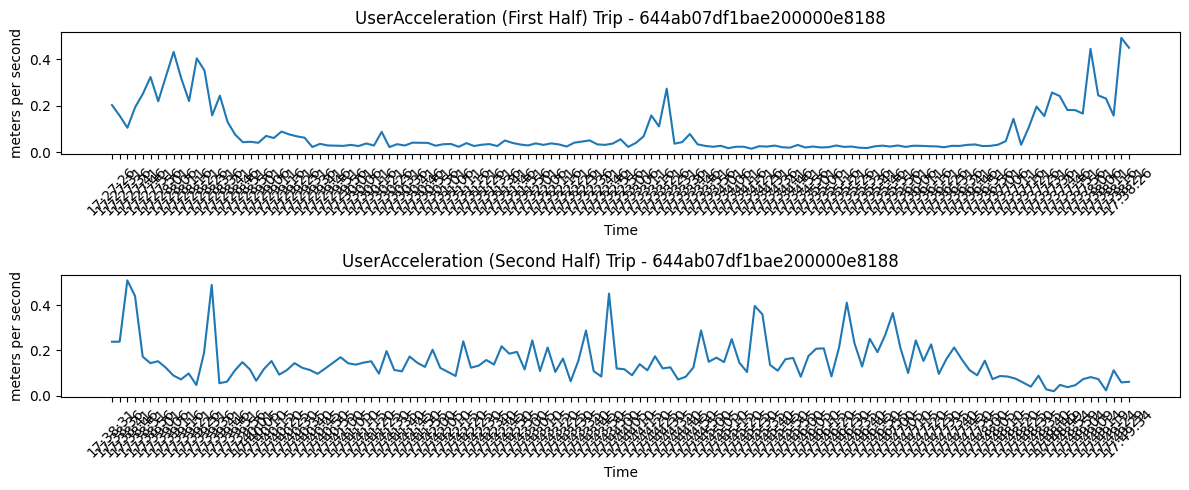

In [24]:
# Plot the speed-time interval chart
timestamp = result['Timestamp']
TimeInterval = len(timestamp) // 2

# Change step for every numbers of steps then a point is plotted
step = 5

# Create the plot figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5))

# Plot the data on the first subplot
ax1.plot(timestamp[:TimeInterval:step], result[plot_y_axis][:TimeInterval:step])

# Selectively display x-axis labels
x = timestamp[:TimeInterval:step].tolist()
xlabel = [str(x_elem)[-8:] for x_elem in x]
ax1.set_xticks(x)
ax1.set_xticklabels(xlabel, rotation=45)
ax1.set_xlabel('Time')
ax1.set_ylabel('meters per second')
ax1.set_title("{} (First Half) Trip - {}".format(plot_y_axis, TRIPLOGID))

# Plot the data on the second subplot
ax2.plot(timestamp[TimeInterval::step], result[plot_y_axis][TimeInterval::step])

# Selectively display x-axis labels
x = timestamp[TimeInterval::step].tolist()
xlabel = [str(x_elem)[-8:] for x_elem in x]
ax2.set_xticks(x)
ax2.set_xticklabels(xlabel, rotation=45)
ax2.set_xlabel('Time')
ax2.set_ylabel('meters per second')
ax2.set_title("{} (Second Half) Trip - {}".format(plot_y_axis, TRIPLOGID))

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [25]:
vibration_df.printSchema()

root
 |-- TripLogId: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- AttitudeReferenceFrame: long (nullable = true)
 |-- Gravity_X: double (nullable = true)
 |-- Gravity_Y: double (nullable = true)
 |-- Gravity_Z: double (nullable = true)
 |-- Attitude_Roll: double (nullable = true)
 |-- Attitude_Pitch: double (nullable = true)
 |-- Attitude_Yaw: double (nullable = true)
 |-- RotationRate_X: double (nullable = true)
 |-- RotationRate_Y: double (nullable = true)
 |-- RotationRate_Z: double (nullable = true)
 |-- UserAcceleration_X: double (nullable = true)
 |-- UserAcceleration_Y: double (nullable = true)
 |-- UserAcceleration_Z: double (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- RotationRate: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- UserAcceleration: double (nullable = true)



In [26]:
result.head()

,TripLogId,Timestamp,AttitudeReferenceFrame,Gravity,Attitude_Roll,Attitude_Pitch,Attitude_Yaw,RotationRate,UserAcceleration
0,644ab07df1bae200000e8188,2023-04-27 17:27:26,3,0.997328,-1.109194,0.019906,-2.897553,0.328482,0.202874
1,644ab07df1bae200000e8188,2023-04-27 17:27:27,3,0.996523,-1.106286,0.019654,-2.895545,0.104514,0.104345
2,644ab07df1bae200000e8188,2023-04-27 17:27:28,3,0.991333,-1.108359,0.030840,-2.890465,0.045264,0.067156
3,644ab07df1bae200000e8188,2023-04-27 17:27:29,3,0.990584,-1.125443,0.042579,-2.892676,0.048049,0.103016
4,644ab07df1bae200000e8188,2023-04-27 17:27:30,3,0.986139,-1.124134,0.045157,-2.903196,0.058191,0.061737


## Return to Home

[Go Back to Quick Links](#Quick_Links)

---

# 4_Data_Preprocessing

In [27]:
# Register the DataFrame as a temporary view
vibration_df.createOrReplaceTempView("vibration")
trips_df.createOrReplaceTempView("trips")

# Query to join vibration data with GPS data
query = """
SELECT 
    V.TripLogId, 
    V.Timestamp,
    MAX(T.StartTime) OVER(PARTITION BY V.TripLogId) AS StartTime,
    MAX(T.EndTime) OVER(PARTITION BY V.TripLogId) AS EndTime,
    MAX(V.RotationRate) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS RotationRate,
    MAX(V.Gravity) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS Gravity,
    AVG(V.UserAcceleration) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS UserAcceleration,
    AVG(V.Attitude_Roll) OVER(PARTITION BY V.TripLogId, V.Attitude_Roll) AS AttitudeRoll,
    AVG(V.Attitude_Pitch) OVER(PARTITION BY V.TripLogId, V.Attitude_Roll) AS AttitudePitch,
    AVG(V.Attitude_Yaw) OVER(PARTITION BY V.TripLogId, V.Attitude_Roll) AS AttitudeYaw,
    MAX(T.Longitude) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS Longitude,
    MAX(T.Latitude) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS Latitude,
    MAX(T.LoadLongitude) OVER(PARTITION BY V.TripLogId) AS LoadLongitude,
    MAX(T.LoadLatitude) OVER(PARTITION BY V.TripLogId) AS LoadLatitude,
    MAX(T.DumpLongitude) OVER(PARTITION BY V.TripLogId) AS DumpLongitude,
    MAX(T.DumpLatitude) OVER(PARTITION BY V.TripLogId) AS DumpLatitude,
    MAX(T.MassTypeMaterial) OVER(PARTITION BY V.TripLogId) AS MassTypeMaterial,
    MAX(T.StartLongitude) OVER(PARTITION BY V.TripLogId) AS StartLongitude,
    MAX(T.StartLatitude) OVER(PARTITION BY V.TripLogId) AS StartLatitude,
    MAX(T.EndLongitude) OVER(PARTITION BY V.TripLogId) AS EndLongitude,
    MAX(T.EndLatitude) OVER(PARTITION BY V.TripLogId) AS EndLatitude,
    MAX(T.speedInKmHr) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS speedInKmHr,
    MAX(T.Quantity) OVER(PARTITION BY V.TripLogId) AS Quantity,
    AVG(V.UserAcceleration_X) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS UserAcceleration_X,
    AVG(V.UserAcceleration_Y) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS UserAcceleration_Y,
    AVG(V.UserAcceleration_Z) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS UserAcceleration_Z,
    AVG(V.Gravity_X) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS Gravity_X,
    AVG(V.Gravity_Y) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS Gravity_Y,
    AVG(V.Gravity_Z) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS Gravity_Z,
    AVG(V.RotationRate_X) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS RotationRate_X,
    AVG(V.RotationRate_Y) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS RotationRate_Y,
    AVG(V.RotationRate_Z) OVER(PARTITION BY V.TripLogId, V.Timestamp) AS RotationRate_Z
FROM vibration AS V
LEFT JOIN trips AS T
ON (V.TripLogId = T.TripLogId AND V.Timestamp = T.Timestamp_formatted)
ORDER BY V.TripLogId, V.Timestamp;
"""

# Execute the queries
joined_vibration = spark.sql(query)

In [28]:
joined_vibration.show(5)

+--------------------+-------------------+--------------------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+-----------------+--------+--------------------+-------------------+--------------------+------------------+--------------------+-------------------+-------------------+--------------------+--------------------+
|           TripLogId|          Timestamp|           StartTime|            EndTime|       RotationRate|           Gravity|   UserAcceleration|      AttitudeRoll|       AttitudePitch|       AttitudeYaw|         Longitude|          Latitude|     LoadLongitude|      LoadLatitude|     DumpLongitude|      DumpLatitude|MassTypeMaterial|    StartLongitude|     StartLatitude|      EndL

In [29]:
# Display the summary of the joined vibration dataframe
summary_df = joined_vibration.describe().toPandas()
summary_df.set_index('summary')

,TripLogId,RotationRate,Gravity,UserAcceleration,AttitudeRoll,AttitudePitch,AttitudeYaw,Longitude,Latitude,LoadLongitude,...,Quantity,UserAcceleration_X,UserAcceleration_Y,UserAcceleration_Z,Gravity_X,Gravity_Y,Gravity_Z,RotationRate_X,RotationRate_Y,RotationRate_Z
summary,,,,,,,,,,,,,,,,,,,,,
count,143852,143852,143852,143852,143852,143852,143852,39407,39407,143852,...,143852,143852,143852,143852,143852,143852,143852,143852,143852,143852
mean,None,0.15623596927572478,0.9973243674256899,0.15863559598340737,-0.5228387742212955,0.14013249011994106,0.04827720883668863,10.354472318173238,59.963731846664224,10.35339239639246,...,22.562564302199483,0.07596631503357833,0.08639346061681742,0.09389903921133971,-0.3740673932351863,-0.10197679153138543,-0.38806184007576106,0.09926926698853093,0.07584124520659005,0.06642140178587032
stddev,None,0.15490339477963855,0.004433276637454552,0.1390538172217366,0.9242263891831826,0.5320052855833456,1.9296649691294034,0.033029077998544265,0.012907501988162897,0.034028358431632585,...,7.778834330764176,0.07923945103456648,0.0864575746132694,0.09316608859056624,0.6932257351109236,0.41908063845283877,0.19381767263928354,0.12285770476904109,0.08263347950584389,0.08007177021214715
min,644a02c58f0db00000c682e0,0.0017946128380417377,0.8444196830757243,2.5859985785758784E-4,-3.0835846291818765,-1.5612349348009606,-3.1406399276489956,10.320111745083794,59.90773674149613,10.320421697472575,...,15,-0.12505632638931274,-0.16310951113700867,-0.23636889457702637,-0.9999883770942688,-0.9696500301361084,-0.8693772554397583,-0.4288170337677002,-0.3060493767261505,-0.2623528242111206
max,644ab4008fe0870000160317,3.446132700483587,1.0449902474222759,2.810551860839913,3.140350538399099,1.3414731477198596,3.141591109285115,10.532535656335762,59.978561042238155,10.529830870125414,...,40,1.4864490032196045,2.2451114654541016,2.1803932189941406,0.9475301504135132,0.9999998807907104,0.2782524526119232,2.979726791381836,2.679109811782837,1.9139171838760376


Here is the second problem. Given the vibration dataset which contains information rounded to the nearest second, I mapped the GPS trip information to it.

There are 143852 rows in the `joined_vibration` dataframe, of which **39407** rows have values for Longitude, Latitude and speedInKmHr. The missing values displayed as null could be imputed with previous detected/calculated speed readings or filled with an algorithm.

## Return to Home

[Go Back to Quick Links](#Quick_Links)

---

# 5_Clustering

## Speed Prediction

### Impute missing speeds with previous `speedInKmHr` reading

In [30]:
from pyspark.sql.window import Window
from pyspark.sql.functions import last, coalesce, row_number

# Define a Window specification
window_spec = Window.orderBy("TripLogId", "Timestamp")
    
# Create a custom function to fill null values with the last known non-null value
def fill_null_with_last(column):
    # fill-forward null values
    last_non_null = last(column, ignorenulls=True).over(window_spec)
    return coalesce(column, last_non_null)

# def calc_missing_speed(column):
#     # Add a running count column within each window
#     df_with_running_count = 
#     # Calculate previous and forward values for speed
#     last_non_null = last(column, ignorenulls=True).over(window_spec)
#     next_non_null = lead(column, ignorenulls=True).over(window_spec)
#     (next_non_null - last_non_null)
#     return coalesce(column, )

# Apply the custom function to fill null values in the target column
joined_vibration = joined_vibration.withColumn("ImputedSpeedInKmHr", fill_null_with_last("speedInKmHr"))

# Apply the custom function to fill null values in the target column
# joined_vibration = joined_vibration.withColumn("Longitude", fill_null_with_last("Longitude"))
# joined_vibration = joined_vibration.withColumn("Latitude", fill_null_with_last("Latitude"))

In [31]:
joined_vibration.show(5)

+--------------------+-------------------+--------------------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+-----------------+--------+--------------------+-------------------+--------------------+------------------+--------------------+-------------------+-------------------+--------------------+--------------------+------------------+
|           TripLogId|          Timestamp|           StartTime|            EndTime|       RotationRate|           Gravity|   UserAcceleration|      AttitudeRoll|       AttitudePitch|       AttitudeYaw|         Longitude|          Latitude|     LoadLongitude|      LoadLatitude|     DumpLongitude|      DumpLatitude|MassTypeMaterial|    StartLongitude|     Start

In [32]:
# Display the summary of the joined vibration dataframe
summary_df = joined_vibration.describe().toPandas()
summary_df.set_index('summary')

,TripLogId,RotationRate,Gravity,UserAcceleration,AttitudeRoll,AttitudePitch,AttitudeYaw,Longitude,Latitude,LoadLongitude,...,UserAcceleration_X,UserAcceleration_Y,UserAcceleration_Z,Gravity_X,Gravity_Y,Gravity_Z,RotationRate_X,RotationRate_Y,RotationRate_Z,ImputedSpeedInKmHr
summary,,,,,,,,,,,,,,,,,,,,,
count,143852,143852,143852,143852,143852,143852,143852,39407,39407,143852,...,143852,143852,143852,143852,143852,143852,143852,143852,143852,143852
mean,None,0.1562359692757282,0.9973243674256945,0.15863559598340451,-0.5228387742213004,0.14013249011994017,0.04827720883668974,10.354472318172801,59.96373184666064,10.3533923963949,...,0.07596631503357831,0.08639346061681735,0.09389903921133967,-0.37406739323518623,-0.1019767915313854,-0.388061840075761,0.09926926698853093,0.07584124520659005,0.06642140178587033,15.841084288996493
stddev,None,0.1549033947796382,0.00443327663745412,0.13905381722173624,0.9242263891831881,0.5320052855833541,1.9296649691294072,0.033029077998539685,0.012907501988143793,0.034028358431613434,...,0.07923945103456628,0.08645757461326954,0.09316608859056642,0.6932257351109223,0.4190806384528405,0.1938176726392826,0.12285770476904198,0.08263347950584385,0.08007177021214669,18.860978911593527
min,644a02c58f0db00000c682e0,0.0017946128380417377,0.8444196830757243,2.5859985785758784E-4,-3.0835846291818765,-1.5612349348009606,-3.1406399276489956,10.320111745083794,59.90773674149613,10.320421697472575,...,-0.12505632638931274,-0.16310951113700867,-0.23636889457702637,-0.9999883770942688,-0.9696500301361084,-0.8693772554397583,-0.4288170337677002,-0.3060493767261505,-0.2623528242111206,0.0
max,644ab4008fe0870000160317,3.446132700483587,1.0449902474222759,2.810551860839913,3.140350538399099,1.3414731477198596,3.141591109285115,10.532535656335762,59.978561042238155,10.529830870125414,...,1.4864490032196045,2.2451114654541016,2.1803932189941406,0.9475301504135132,0.9999998807907104,0.2782524526119232,2.979726791381836,2.679109811782837,1.9139171838760376,89.83682216564075


In [33]:
joined_vibration.printSchema()

root
 |-- TripLogId: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- StartTime: timestamp (nullable = true)
 |-- EndTime: timestamp (nullable = true)
 |-- RotationRate: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- UserAcceleration: double (nullable = true)
 |-- AttitudeRoll: double (nullable = true)
 |-- AttitudePitch: double (nullable = true)
 |-- AttitudeYaw: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- LoadLongitude: double (nullable = true)
 |-- LoadLatitude: double (nullable = true)
 |-- DumpLongitude: double (nullable = true)
 |-- DumpLatitude: double (nullable = true)
 |-- MassTypeMaterial: string (nullable = true)
 |-- StartLongitude: double (nullable = true)
 |-- StartLatitude: double (nullable = true)
 |-- EndLongitude: double (nullable = true)
 |-- EndLatitude: double (nullable = true)
 |-- speedInKmHr: double (nullable = true)
 |-- Quantity: integer (nullable 

In [34]:
# Select relevant columns (latitude, longitude, speed, vibration, and material transported)
df = joined_vibration.select(
    'TripLogId', 'Timestamp', 
    'UserAcceleration','RotationRate', 'Gravity',
    'UserAcceleration_X', 'UserAcceleration_Y', 'UserAcceleration_Z',
    'Gravity_X', 'Gravity_Y', 'Gravity_Z',
    'RotationRate_X', 'RotationRate_Y', 'RotationRate_Z',
    'AttitudeRoll', 'AttitudePitch', 'AttitudeYaw',
    'Longitude', 'Latitude',
    'ImputedSpeedInKmHr', 'MassTypeMaterial', 'Quantity'
)

# Drop rows with missing values (if necessary)
# df = df.dropna()
# Drop null values for the specified column
df = df.na.drop(subset=['ImputedSpeedInKmHr'])

In [35]:
import seaborn as sns

df_toPandas = df.toPandas()

df_toPandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143852 entries, 0 to 143851
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   TripLogId           143852 non-null  object        
 1   Timestamp           143852 non-null  datetime64[ns]
 2   UserAcceleration    143852 non-null  float64       
 3   RotationRate        143852 non-null  float64       
 4   Gravity             143852 non-null  float64       
 5   UserAcceleration_X  143852 non-null  float64       
 6   UserAcceleration_Y  143852 non-null  float64       
 7   UserAcceleration_Z  143852 non-null  float64       
 8   Gravity_X           143852 non-null  float64       
 9   Gravity_Y           143852 non-null  float64       
 10  Gravity_Z           143852 non-null  float64       
 11  RotationRate_X      143852 non-null  float64       
 12  RotationRate_Y      143852 non-null  float64       
 13  RotationRate_Z      143852 no

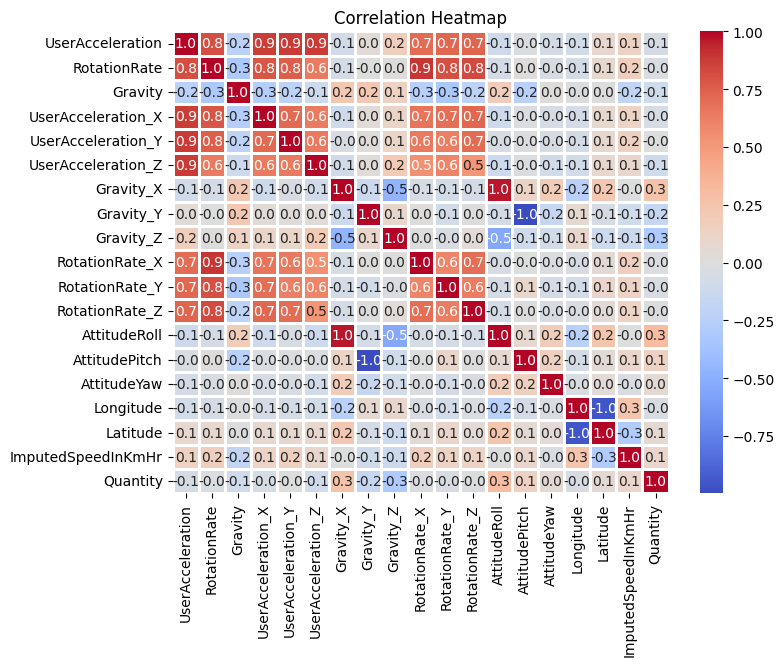

In [36]:
# Calculate the correlation matrix
correlation_matrix = df_toPandas.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.8)
plt.title('Correlation Heatmap')
plt.show()

del df_toPandas

In [37]:
# Add features here for clustering. They should be independent or unrelated features
feature_inputs = ['UserAcceleration', 'ImputedSpeedInKmHr']
# feature_inputs = ['Gravity' ,'UserAcceleration', 'ImputedSpeedInKmHr']
# feature_inputs = ['UserAcceleration']

## Data Preparation for clustering:

Vectorize features and standard scaling

In [38]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

# Vectorize the features into a numpy array so that it will be contained in a single column
assembler = VectorAssembler(inputCols=feature_inputs, outputCol='features')
df = assembler.transform(df)

# Initialize the StandardScaler
scaler = StandardScaler(inputCol='features', outputCol="scaledfeatures", withMean=True, withStd=True)

# Fit and transform the data
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Show the scaled data
df.select("TripLogId", "Timestamp", "scaledfeatures").show()

+--------------------+-------------------+--------------------+
|           TripLogId|          Timestamp|      scaledfeatures|
+--------------------+-------------------+--------------------+
|644a02c58f0db0000...|2023-04-27 05:06:13|[1.59096570344246...|
|644a02c58f0db0000...|2023-04-27 05:06:14|[-0.0097257583606...|
|644a02c58f0db0000...|2023-04-27 05:06:15|[1.48376258695035...|
|644a02c58f0db0000...|2023-04-27 05:06:16|[-0.2800589192321...|
|644a02c58f0db0000...|2023-04-27 05:06:17|[-0.2371710715537...|
|644a02c58f0db0000...|2023-04-27 05:06:18|[-0.2264934986201...|
|644a02c58f0db0000...|2023-04-27 05:06:19|[0.19364737468668...|
|644a02c58f0db0000...|2023-04-27 05:06:20|[0.22834609057861...|
|644a02c58f0db0000...|2023-04-27 05:06:21|[0.25459777741928...|
|644a02c58f0db0000...|2023-04-27 05:06:22|[-0.7250518348827...|
|644a02c58f0db0000...|2023-04-27 05:06:23|[0.29424790555097...|
|644a02c58f0db0000...|2023-04-27 05:06:24|[0.30998837484994...|
|644a02c58f0db0000...|2023-04-27 05:06:2

### Clustering - K-Means

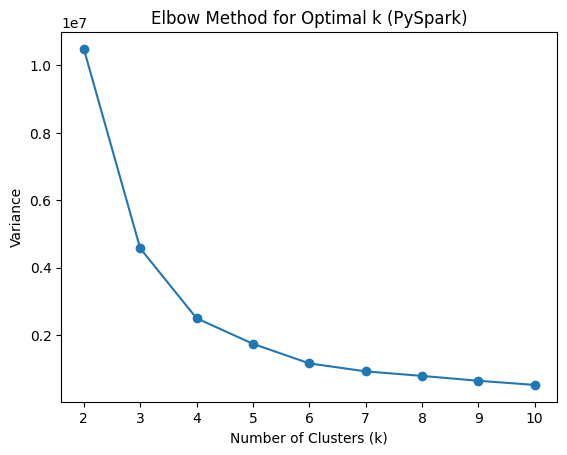

In [39]:
SEED_VALUE = 42

from pyspark.ml.clustering import KMeans

# Calculate variance for different numbers of clusters
variances = []
for k in range(2, 11):
    elbow_kmeans = KMeans(featuresCol='features', k=k, seed=42)
    elbow_model = elbow_kmeans.fit(df)
    cost = elbow_model.summary.trainingCost
    variances.append(cost)

# Plot the elbow curve
plt.plot(range(2, 11), variances, marker='o')
plt.title('Elbow Method for Optimal k (PySpark)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Variance')
plt.show()

In [40]:
# Specify the number of clusters (K)
num_clusters = 3
colors = ['b', 'r', 'g']

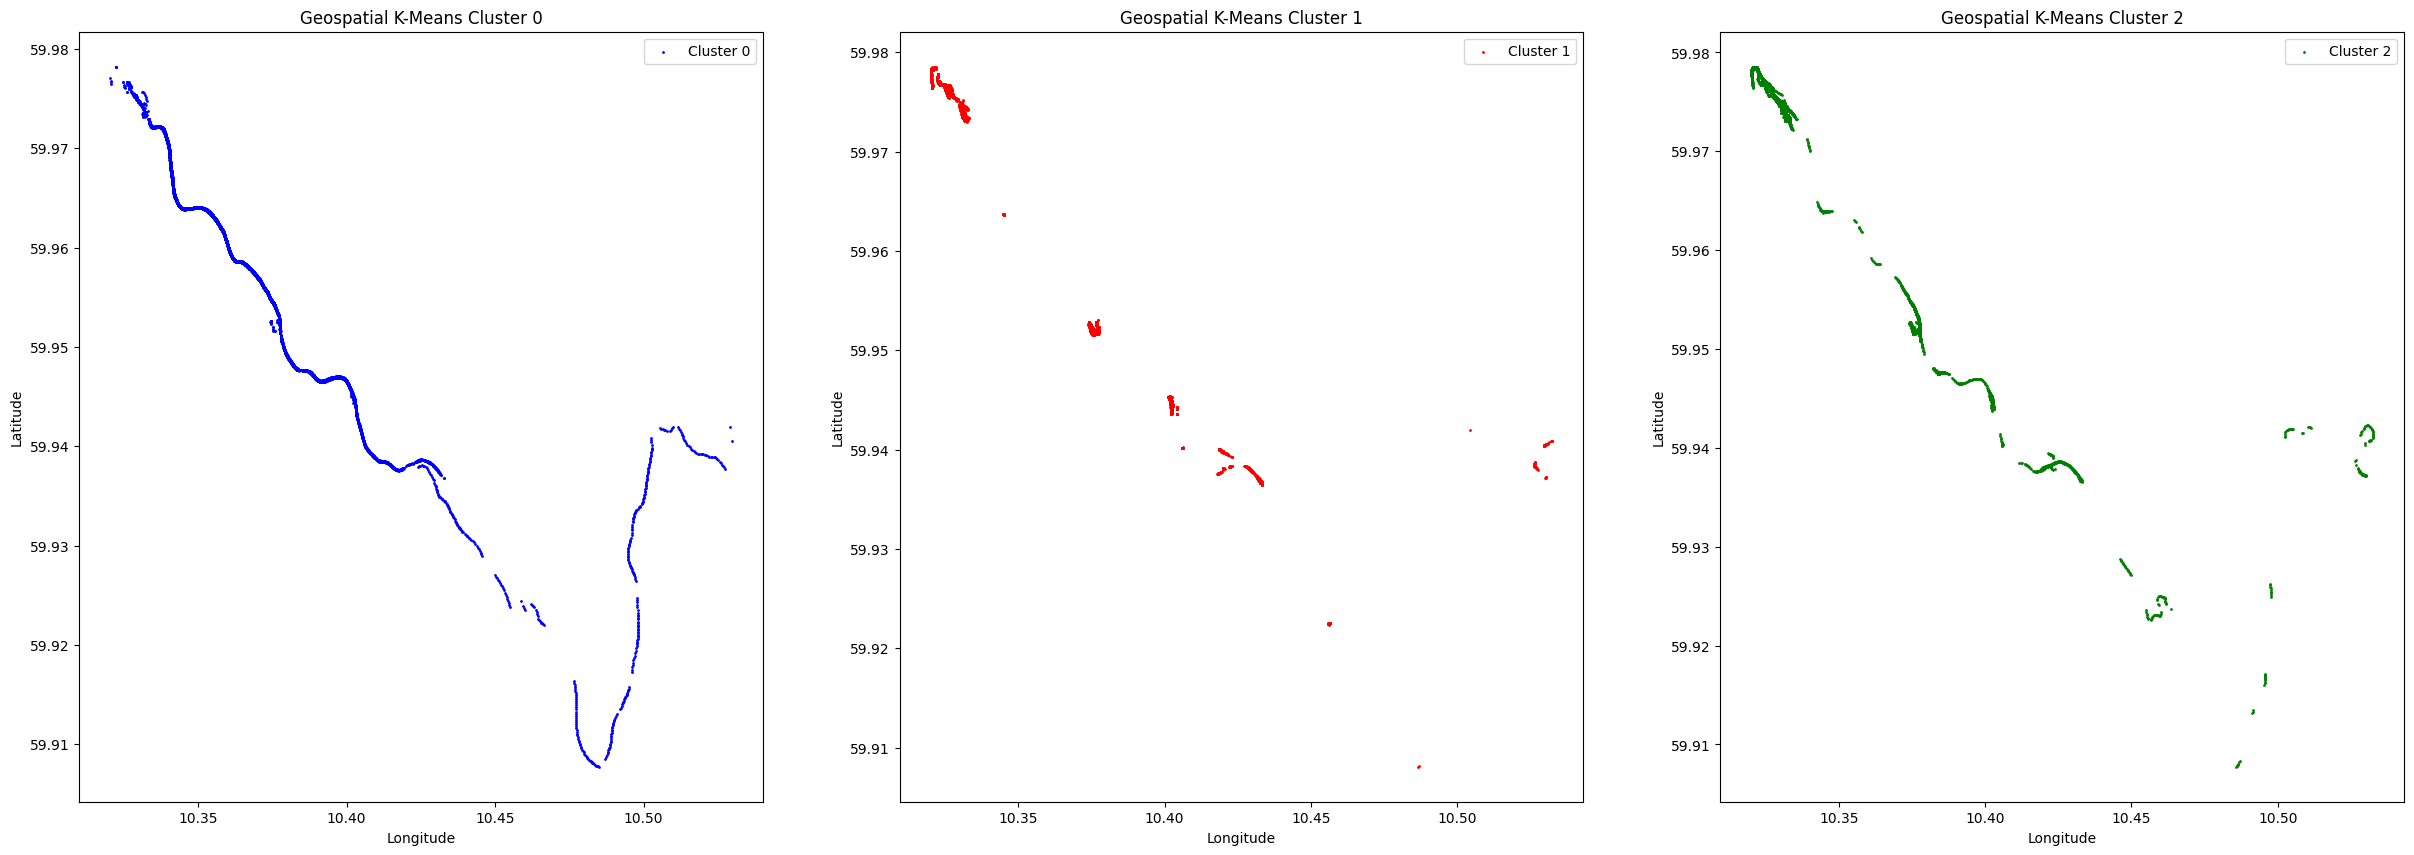

In [41]:
# Fit a K-Means model to the feature vector
kmeans = KMeans(k=num_clusters, seed=SEED_VALUE)
model = kmeans.fit(df)

# Predict cluster labels for the data points
predict_df = model.transform(df)

# Visualize the clusters
cluster_centers = model.clusterCenters()

# Calculate the number of clusters
num_clusters = len(cluster_centers)

# Create a subplot grid with 2 row and 'num_clusters' 2 columns
# fig, axes = plt.subplots(2, (num_clusters // 2), figsize=(15, 15))
fig, axes = plt.subplots(1, num_clusters, figsize=(30, 10))

# Flatten the 2x2 array of axes to iterate over each subplot
# axes = axes.flatten()

for cluster_id, center in enumerate(cluster_centers):
    cluster_data = predict_df.filter(predict_df["prediction"] == cluster_id)
    ax = axes[cluster_id]
    ax.scatter(
        cluster_data.select("Longitude").rdd.flatMap(lambda x: x).collect(),
        cluster_data.select("Latitude").rdd.flatMap(lambda x: x).collect(),
        c=colors[cluster_id],
        label=f'Cluster {cluster_id}',
        s=1
    )
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Geospatial K-Means Cluster {cluster_id}')
    ax.legend()

In [42]:
# Access cluster centers (centroid coordinates)
print("Cluster Centers:")
for cluster_id, center in enumerate(cluster_centers):
    print(f"Cluster {cluster_id}: {center}")

# Access cluster sizes
cluster_sizes = predict_df.groupBy("prediction").count()
print("Cluster Sizes:")
cluster_sizes.show()

Cluster Centers:
Cluster 0: [ 0.16931999 54.05680681]
Cluster 1: [0.1384982  4.00640282]
Cluster 2: [ 0.2134693 25.7001317]
Cluster Sizes:


+----------+-----+
|prediction|count|
+----------+-----+
|         1|92840|
|         2|30001|
|         0|21011|
+----------+-----+



### Clustering - Expectation Maximization Algorithm

In [43]:
from pyspark.ml.clustering import GaussianMixture

# Fit a Gaussian Mixture Model (GMM) using the EM algorithm to the feature vector
gmm = GaussianMixture(k=num_clusters, seed=SEED_VALUE)
model = gmm.fit(df)

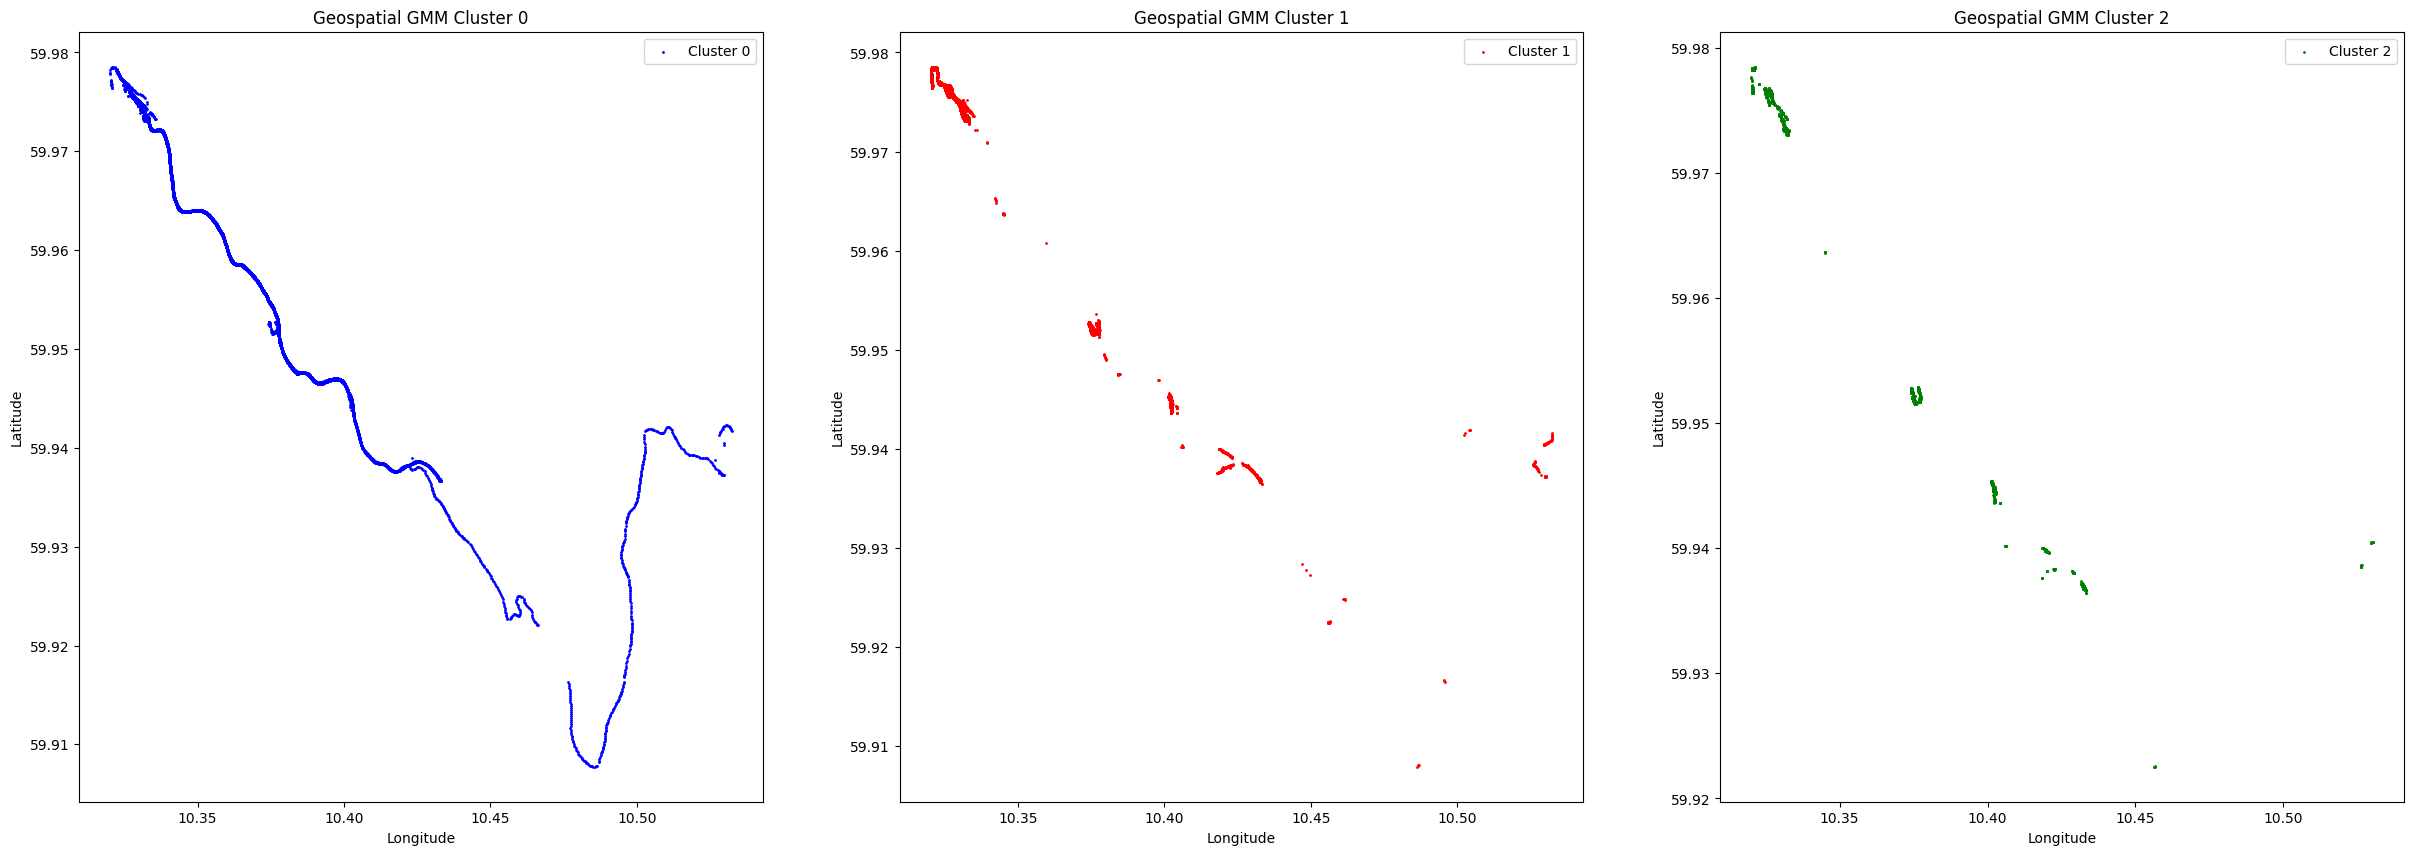

In [44]:
# Predict cluster labels for the data points
predict_df = model.transform(df)

# Visualize the clusters
cluster_centers = model.gaussiansDF.select("mean").collect()

# Calculate the number of clusters
num_clusters = len(cluster_centers)

# Create a subplot grid with 2 row and 'num_clusters' 2 columns
# fig, axes = plt.subplots(2, (num_clusters // 2), figsize=(15, 15))
fig, axes = plt.subplots(1, (num_clusters), figsize=(30, 10))

# Flatten the 2x2 array of axes to iterate over each subplot
# axes = axes.flatten()

for cluster_id, center in enumerate(cluster_centers):
    cluster_data = predict_df.filter(predict_df["prediction"] == cluster_id)
    ax = axes[cluster_id]
    ax.scatter(cluster_data.select("Longitude").rdd.flatMap(lambda x: x).collect(),
               cluster_data.select("Latitude").rdd.flatMap(lambda x: x).collect(),
               c=colors[cluster_id], label=f'Cluster {cluster_id}', s=1)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Geospatial GMM Cluster {cluster_id}')
    ax.legend()

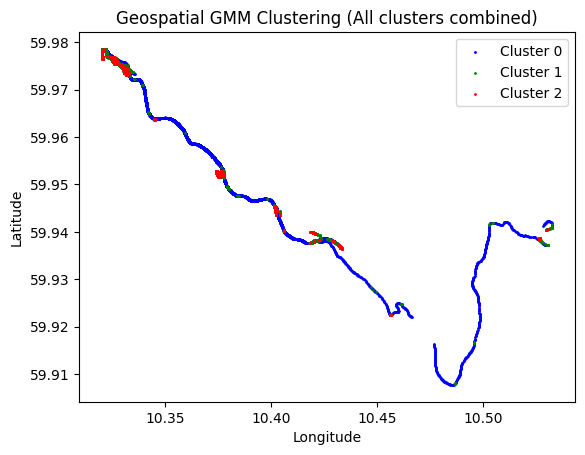

In [45]:
# Visualize the clusters
colors = ['b', 'g', 'r']
for cluster_id in [0, 1, 2]: # 26th April clusters
    cluster_data = predict_df[predict_df['prediction'] == cluster_id]
    plt.scatter(cluster_data.select("Longitude").rdd.flatMap(lambda x: x).collect(),
                cluster_data.select("Latitude").rdd.flatMap(lambda x: x).collect(),
                c=colors[cluster_id], label=f'Cluster {cluster_id}', s= 1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial GMM Clustering (All clusters combined)')
plt.legend()
plt.show()

In [46]:
# Access cluster parameters (means and covariances)
cluster_means = model.gaussiansDF.select("mean").collect()
cluster_covariances = model.gaussiansDF.select("cov").collect()
print("Cluster Means:")
for cluster_id, mean in enumerate(cluster_means):
    print(f"Cluster {cluster_id}: {mean[0]}")
print("Cluster Covariances:")
for cluster_id, cov in enumerate(cluster_covariances):
    print(f"Cluster {cluster_id}: {cov[0]}")
    
# Access cluster sizes
cluster_sizes = predict_df.groupBy("prediction").count()
print("Cluster Sizes:")
cluster_sizes.show()

Cluster Means:
Cluster 0: [0.1574000866358303,40.12161242320546]
Cluster 1: [0.2622815291201232,10.581507344541718]
Cluster 2: [0.07266781888919667,1.8679651544159448]
Cluster Covariances:
Cluster 0: DenseMatrix([[7.98462120e-03, 1.39757356e-01],
             [1.39757356e-01, 2.73744545e+02]])
Cluster 1: DenseMatrix([[2.93712112e-02, 1.35143569e-01],
             [1.35143569e-01, 5.75143233e+01]])
Cluster 2: DenseMatrix([[0.0031169 , 0.02282683],
             [0.02282683, 3.06190089]])
Cluster Sizes:


+----------+-----+
|prediction|count|
+----------+-----+
|         1|47271|
|         2|58259|
|         0|38322|
+----------+-----+



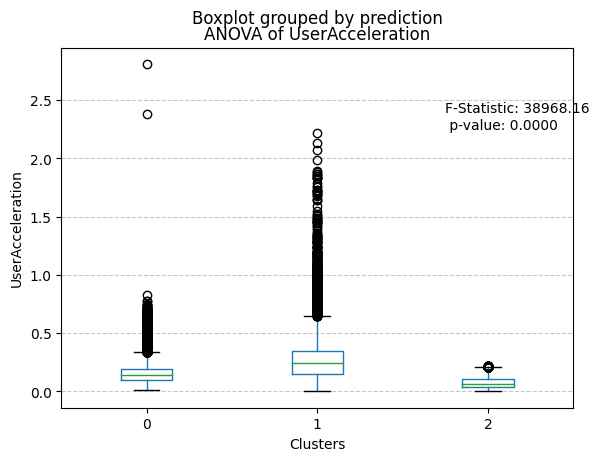

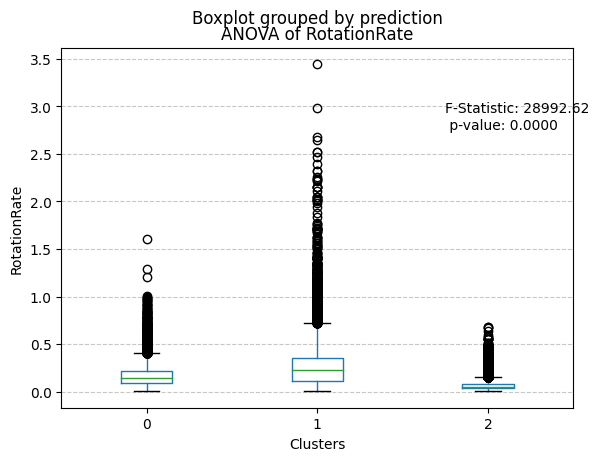

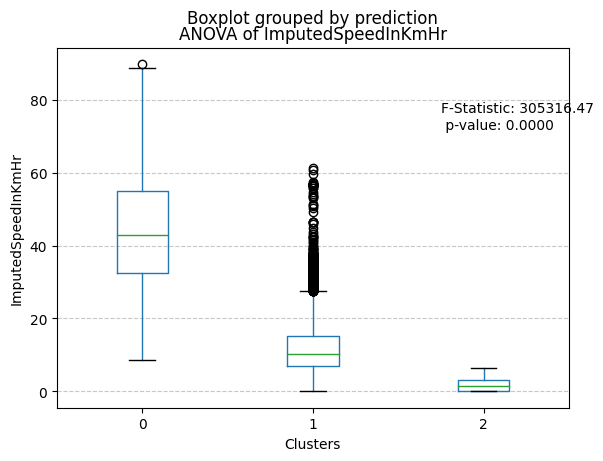

In [47]:
import pandas as pd
from scipy import stats

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = predict_df.toPandas()

# Use below features for ANOVA box-plot
features = ["UserAcceleration", "RotationRate", "ImputedSpeedInKmHr"]

for feature in features:
    # Perform one-way ANOVA using Pandas
    grouped_data = [pandas_df[pandas_df["prediction"] == group][feature] 
                    for group in pandas_df["prediction"].unique()]
    f_statistic, p_value = stats.f_oneway(*grouped_data)
    ax = pandas_df.boxplot(column=feature, by="prediction", grid=False)
    
    # Set plot labels and title
    ax.set_xlabel('Clusters')
    ax.set_ylabel(feature)
    ax.set_title(f'ANOVA of {feature}')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text with F-statistic and p-value
    textstr = f'F-Statistic: {f_statistic:.2f}\n p-value: {p_value:.4f}'
    ax.text(0.75, 0.85, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top')


In [48]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import radians, sum, count

cluster_centroids = []

for cluster in range(num_clusters):
    cluster_criteria = (predict_df['prediction'] == cluster)
    df = predict_df[cluster_criteria]

    # Convert degrees to radians
    df = df.withColumn("latitude_rad", radians(df["latitude"]))
    df = df.withColumn("longitude_rad", radians(df["longitude"]))

    # Calculate the weighted sum of latitude and longitude
    sum_lat = df.agg(sum("latitude_rad")).collect()[0][0]
    sum_lon = df.agg(sum("longitude_rad")).collect()[0][0]

    # Calculate the total weight (number of points)
    total_weight = df.agg(count("*").alias("count")).collect()[0]["count"]

    # Calculate the centroid in radians
    centroid_lat = sum_lat / total_weight
    centroid_lon = sum_lon / total_weight
    
    # Convert the centroid back to degrees
    cluster_centroids.append((centroid_lat * (180/3.14159), centroid_lon * (180/3.14159)))

    print("Centroid ", cluster, "(Latitude, Longitude):", cluster_centroids[cluster])


Centroid  0 (Latitude, Longitude): (30.513634600918802, 5.273552205816449)


Centroid  1 (Latitude, Longitude): (19.09234283499494, 3.293732792035577)


Centroid  2 (Latitude, Longitude): (4.997255934476116, 0.862492058814415)


In [49]:
import os

# Specify the export location
export_path = "model/" 

# Check if the folder exists
if not os.path.exists(export_path):
    # Save the GMM model to the export location
    model.save(export_path)

In [50]:
pandas_df.head(50)

,TripLogId,Timestamp,UserAcceleration,RotationRate,Gravity,UserAcceleration_X,UserAcceleration_Y,UserAcceleration_Z,Gravity_X,Gravity_Y,...,AttitudeYaw,Longitude,Latitude,ImputedSpeedInKmHr,MassTypeMaterial,Quantity,features,scaledfeatures,probability,prediction
0,644a02c58f0db00000c682e0,2023-04-27 05:06:13,0.379865,0.418579,0.999810,0.258475,0.276985,0.027706,0.736212,-0.028862,...,1.351065,10.374329,59.952582,0.000000,Stone,30,"[0.3798654501159461, 0.0]","[1.5909657034424631, -0.8398866444444595]","[0.0037624513027733563, 0.9962366845436847, 8....",1
1,644a02c58f0db00000c682e0,2023-04-27 05:06:14,0.157283,0.212053,1.000000,0.050233,0.100312,0.110237,0.739241,-0.019638,...,1.364920,10.374338,59.952596,5.650866,Stone,30,"[0.15728319215798275, 5.650866323750554]","[-0.009725758360645962, -0.5402804389427358]","[0.05224793857453071, 0.4099193227004952, 0.53...",2
2,644a02c58f0db00000c682e0,2023-04-27 05:06:15,0.364958,0.463484,0.999847,0.097552,0.060872,0.346371,0.740922,-0.020139,...,1.391079,NaN,NaN,5.650866,Stone,30,"[0.3649584475496522, 5.650866323750554]","[1.4837625869503566, -0.5402804389427358]","[0.005656051697396373, 0.9943264524774017, 1.7...",1
3,644a02c58f0db00000c682e0,2023-04-27 05:06:16,0.119692,0.117190,0.999988,0.059969,0.052357,0.089379,0.737255,-0.023991,...,1.366232,NaN,NaN,5.650866,Stone,30,"[0.11969233421718457, 5.650866323750554]","[-0.2800589192321345, -0.5402804389427358]","[0.0407070076745609, 0.2779443623848623, 0.681...",2
4,644a02c58f0db00000c682e0,2023-04-27 05:06:17,0.125656,0.175499,0.999975,0.052031,0.035242,0.108813,0.745912,-0.023920,...,1.303589,NaN,NaN,5.650866,Stone,30,"[0.12565605314928663, 5.650866323750554]","[-0.23717107155376213, -0.5402804389427358]","[0.04214119679750506, 0.29160999535778714, 0.6...",2
5,644a02c58f0db00000c682e0,2023-04-27 05:06:18,0.127141,0.320074,0.999976,0.058963,0.064036,0.092669,0.746622,-0.025249,...,1.218537,NaN,NaN,5.650866,Stone,30,"[0.12714081042436615, 5.650866323750554]","[-0.2264934986201697, -0.5402804389427358]","[0.0425258835593004, 0.2954033433470602, 0.662...",2
6,644a02c58f0db00000c682e0,2023-04-27 05:06:19,0.185563,0.293107,0.999759,0.077872,0.145216,0.085334,0.744409,-0.016241,...,1.050151,10.374404,59.952600,2.659407,Stone,30,"[0.18556300262855885, 2.659406657002189]","[0.19364737468668997, -0.6988861868612372]","[0.019646540066521268, 0.2024927978902535, 0.7...",2
7,644a02c58f0db00000c682e0,2023-04-27 05:06:20,0.190388,0.309429,0.999955,0.076990,0.075438,0.156937,0.746906,-0.019995,...,0.855130,10.374439,59.952588,8.532793,Stone,30,"[0.19038799152602395, 8.532792997060657]","[0.22834609057861793, -0.38748207747812285]","[0.10921504106562735, 0.8855880137105172, 0.00...",1
8,644a02c58f0db00000c682e0,2023-04-27 05:06:21,0.194038,0.230200,0.999943,0.059645,0.077829,0.167440,0.746569,-0.025766,...,0.655590,10.374463,59.952570,8.519242,Stone,30,"[0.19403838878972837, 8.519241972616669]","[0.2545977774192853, -0.3882005462547174]","[0.10609188699416969, 0.8890306090545027, 0.00...",1
9,644a02c58f0db00000c682e0,2023-04-27 05:06:22,0.057814,0.224804,0.999774,0.023487,0.040512,0.033906,0.727386,-0.024368,...,0.455268,10.374482,59.952553,7.992017,Stone,30,"[0.05781437065934119, 7.992017113042061]","[-0.7250518348827155, -0.41615375388226705]","[0.13493119020859035, 0.8319305864775307, 0.03...",1


In [51]:
pandas_df.to_csv(f'trips_final_{REPORTING_DATE}', index=False)